In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
df2 = pd.read_csv("lego_data/Data/lego_with_type.csv", sep = ",", encoding = "latin1")

df2

,Set_Name,Theme,Pieces,Price,Pages,Unique_Pieces,build_type
0,Creative Blue Bricks,Classic,52.0,4.99,37.0,28.0,other
1,Creative Green Bricks,Classic,60.0,4.99,37.0,36.0,other
2,Fire Truck,DUPLO,6.0,6.99,3.0,6.0,transport
3,Tow Truck,DUPLO,7.0,6.99,3.0,7.0,transport
4,Stephanie's Summer Heart Box,Friends,95.0,7.99,40.0,52.0,other
...,...,...,...,...,...,...,...
917,Welcome to Apocalypseburg!,THE LEGO MOVIE 2,3178.0,299.99,452.0,692.0,other
918,Jurassic Park: T. rex Rampage,Jurassic World,3120.0,249.99,464.0,525.0,other
919,Monkie Kid's Team Secret HQ,Monkie Kid,1105.0,169.99,556.0,622.0,building
920,Grand Piano,Ideas,3662.0,349.99,564.0,345.0,other


### VIF analyse for grad av multikollinearitet:

In [8]:
selected_columns = ['Pieces', 'Unique_Pieces', 'build_type']

# Create a new DataFrame with only the selected columns
filtered_data = df2[selected_columns]
data = pd.get_dummies(filtered_data, columns=['build_type'], drop_first=True).astype(int)

# Check for NaN values and drop if necessary
data = data.dropna()

# Check if data is empty after transformations
if data.empty:
    raise ValueError("Data is empty after encoding and cleaning. Check input data for issues.")
else:
    print("Data has shape:", data.shape)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = data.columns
vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

print(vif_data)

Data has shape: (922, 4)
                feature       VIF
0                Pieces  4.095123
1         Unique_Pieces  5.704100
2      build_type_other  1.641345
3  build_type_transport  1.361118


### Antall sett i hver kategori:

In [17]:
print(df2['build_type'].value_counts())

build_type
other        545
transport    271
building     106
Name: count, dtype: int64


### Plot av pris per antall brikker:

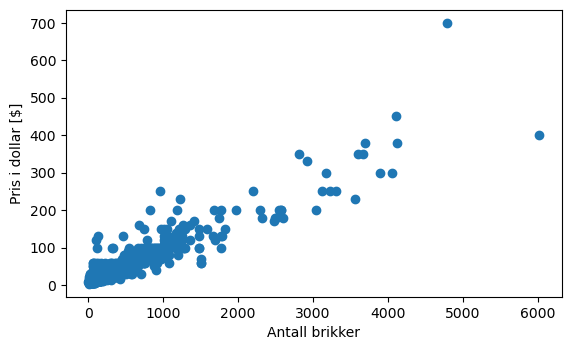

In [18]:
plt.scatter(df2['Pieces'], df2['Price'])
plt.xlabel('Antall brikker')
plt.ylabel('Pris i dollar [$]')
plt.gca().set_aspect(5)
plt.show()

### Pair plot (funker ikke)

In [ ]:
sns.pairplot(df2, vars = ['Price', 'Pieces', 'Pages', 'Unique_Pieces', 'build_type'],
             hue = 'Theme', 
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

### Enkel lineær regresjon på pris og antall deler:

In [5]:
formel = 'Price ~ Pieces'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     5415.
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:25:54   Log-Likelihood:                -4161.6
No. Observations:                 922   AIC:                             8327.
Df Residuals:                     920   BIC:                             8337.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8962      0.894      9.951      0.000       7.142      10.651
Pieces         0.0872      0.001     73.589      0.000       0.085       0.090
==============================================================================
Omnibus:                      736.003   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45431.936
Skew:                           3.115   Prob(JB):                         0.00
Kurtosis:                      36.820   Cond. No.                         927.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

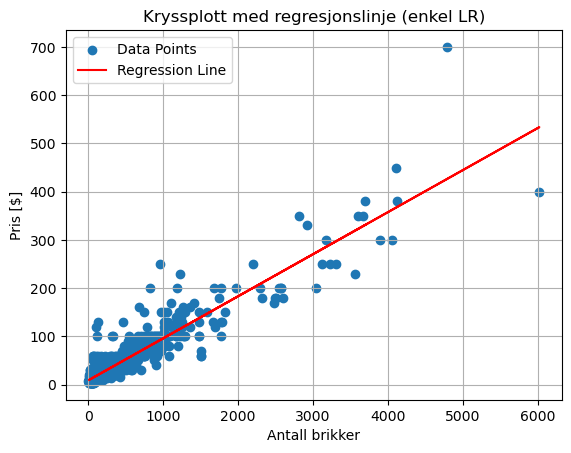

In [6]:
slope = resultat.params['Pieces']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Pieces'])

regression_y = slope * regression_x + intercept

plt.scatter(df2['Pieces'], df2['Price'], label='Data Points')
plt.plot(regression_x, regression_y, color='red', label='Regression Line')
plt.xlabel('Antall brikker')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinje (enkel LR)')
plt.legend()
plt.grid()
plt.show()

### Enkel lineær regresjon på hver kategori:

In [5]:
# enkel LR for hvert tema hver for seg
mythemes = ['transport', 'building', 'other']
subset_df = df2[df2['build_type'].isin(mythemes)]
resultater = []
for i, theme in enumerate(mythemes):
    modell3 = smf.ols('Price ~ Pieces' , data = subset_df[subset_df['build_type'].isin([theme])])
    resultater.append(modell3.fit())

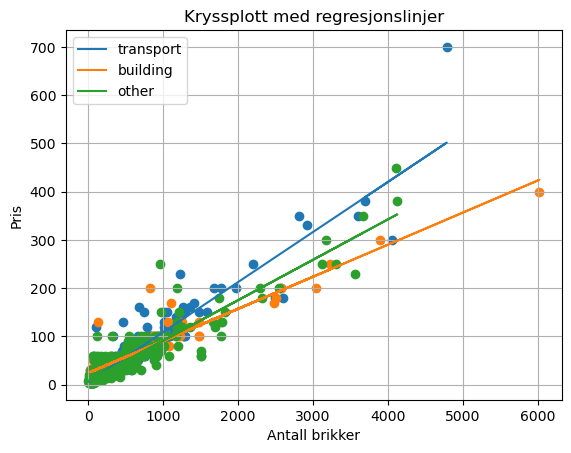

In [6]:
# plott av dataene og regresjonslinjene
for i, theme in enumerate(mythemes):
    slope = resultater[i].params['Pieces']
    intercept = resultater[i].params['Intercept']

    regression_x = np.array(subset_df[subset_df['build_type'].isin([theme])]['Pieces'])
    regression_y = slope * regression_x + intercept

    # Plot scatter plot and regression line
    plt.scatter(subset_df[subset_df['build_type'].isin([theme])]['Pieces'], subset_df[subset_df['build_type'].isin([theme])]['Price'], color=plt.cm.tab10(i))
    plt.plot(regression_x, regression_y, color=plt.cm.tab10(i), label=theme)
    
plt.xlabel('Antall brikker')
plt.ylabel('Pris')
plt.title('Kryssplott med regresjonslinjer')
plt.legend()
plt.grid()
plt.show()

## Multipell lineær regresjon:

In [9]:
# multippel lineær regresjon
modell3_mlr = smf.ols('Price ~ Unique_Pieces + Pieces + build_type' , data = subset_df)
modell3_mlr.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     1399.
Date:                Mon, 11 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:24:00   Log-Likelihood:                -4147.5
No. Observations:                 922   AIC:                             8305.
Df Residuals:                     917   BIC:                             8329.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   7.8444      2.526      3.106      0.002       2.887      12.801
build_type[T.other]        -3.4561      2.368     -1.459      0.145      -8.104       1.192
build_type[T.transport]     4.0201      2.536      1.585      0.113      -0.957       8.997
Unique_Pieces               0.0301      0.011      2.737      0.006       0.009       0.052
Pieces                      0.0822      0.002     42.116      0.000       0.078       0.086
==============================================================================
Omnibus:                      796.005   Durbin-Watson:                   1.772
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58512.229
Skew:                           3.480   Prob(JB):                         0.00
Kurtosis:                      41.401   Cond. No.                     4.30e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Evaluering:

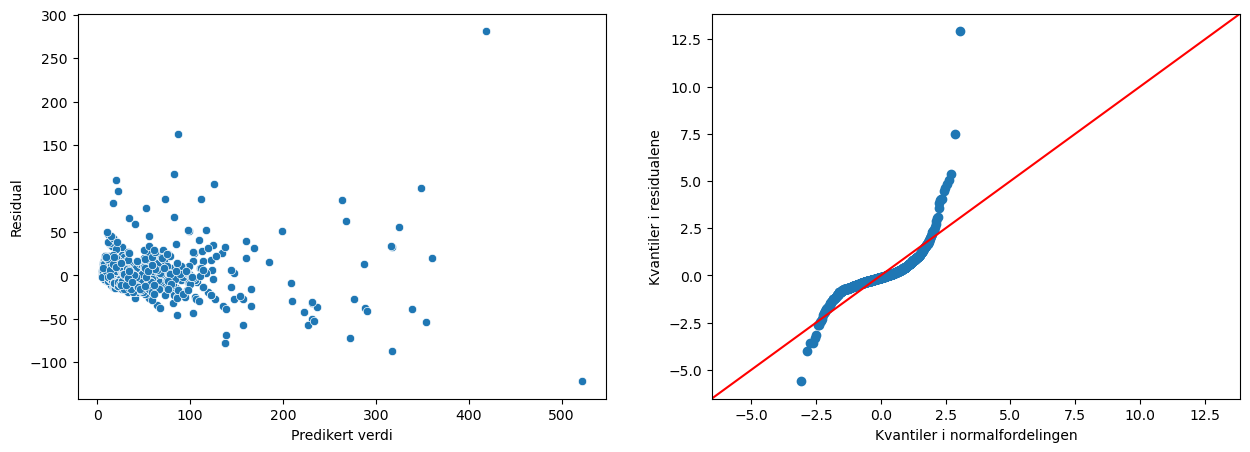

In [13]:
# Steg 5: Evaluere om modellen passer til dataene
# Plotte predikert verdi mot residual
figure, axis = plt.subplots(1, 2, figsize = (15, 5))
sns.scatterplot(x = modell3_mlr.fit().fittedvalues, y = modell3_mlr.fit().resid, ax = axis[0])
axis[0].set_ylabel("Residual")
axis[0].set_xlabel("Predikert verdi")

# Lage kvantil-kvantil-plott for residualene
sm.qqplot(modell3_mlr.fit().resid, line = '45', fit = True, ax = axis[1])
axis[1].set_ylabel("Kvantiler i residualene")
axis[1].set_xlabel("Kvantiler i normalfordelingen")
plt.show()